In [1]:
from pyspark.sql import SparkSession

spark = (
    SparkSession
    .builder
    .appName("PySpark Project")
    .master("spark://DESKTOP-NE6TNMG:7077")
    .config("spark.executor.instances", "2")
    .config("spark.executor.cores", "1")
    .config("spark.executor.memory", "1g")
    .getOrCreate()
)

spark

26/02/13 21:55:02 WARN Utils: Your hostname, DESKTOP-NE6TNMG resolves to a loopback address: 127.0.1.1; using 10.99.245.178 instead (on interface wifi0)
26/02/13 21:55:02 WARN Utils: Set SPARK_LOCAL_IP if you need to bind to another address
Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).
26/02/13 21:55:03 WARN NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable


In [2]:
pro = spark.read.format("csv").option("header",True).option("inferSchema",True).load("/home/suhaib/csv_Folder/data_Folder/Sales.csv")


In [3]:
pro.show(5)

[Stage 2:>                                                          (0 + 1) / 1]

+----------+---+--------+----+------------+--------------+---------------+---------+----------------+----------------+------------+-------------------+--------------+---------+----------+------+----+-------+
|      Date|Day|   Month|Year|Customer_Age|     Age_Group|Customer_Gender|  Country|           State|Product_Category|Sub_Category|            Product|Order_Quantity|Unit_Cost|Unit_Price|Profit|Cost|Revenue|
+----------+---+--------+----+------------+--------------+---------------+---------+----------------+----------------+------------+-------------------+--------------+---------+----------+------+----+-------+
|2013-11-26| 26|November|2013|          19|   Youth (<25)|              M|   Canada|British Columbia|     Accessories|  Bike Racks|Hitch Rack - 4-Bike|             8|       45|       120|   590| 360|    950|
|2015-11-26| 26|November|2015|          19|   Youth (<25)|              M|   Canada|British Columbia|     Accessories|  Bike Racks|Hitch Rack - 4-Bike|             8|  

#  The Total Number of Rows

In [4]:
total_rows = pro.count()

print(f"The Total Number of Rows : {total_rows}")

[Stage 3:==============>                                            (1 + 3) / 4]

The Total Number of Rows : 113036


# Checking Duplicates

In [5]:
from pyspark.sql.functions import col, count, sum, max, min

duplicate_rows = pro.groupBy(pro.columns).count().filter(col("count") > 1)

In [6]:
# Count total repeated rows (subtract 1 for each duplicate row type)

total_repeated_rows = duplicate_rows.withColumn("repeated_count", col("count") - 1) \
                                    .agg(sum("repeated_count").alias("total_repeated")) \
                                    .collect()[0]["total_repeated"]

print(f"Total repeated rows in dataset: {total_repeated_rows}")


[Stage 8:============================================>              (3 + 1) / 4]

Total repeated rows in dataset: 1000


# Drop Duplicates values

In [7]:
pro_max = pro.dropDuplicates()

In [8]:
p = pro_max.count()
print(f"total_rows : {p}")

[Stage 14:>                                                         (0 + 4) / 4]

total_rows : 112036


In [9]:
pro_max.printSchema()

root
 |-- Date: date (nullable = true)
 |-- Day: integer (nullable = true)
 |-- Month: string (nullable = true)
 |-- Year: integer (nullable = true)
 |-- Customer_Age: integer (nullable = true)
 |-- Age_Group: string (nullable = true)
 |-- Customer_Gender: string (nullable = true)
 |-- Country: string (nullable = true)
 |-- State: string (nullable = true)
 |-- Product_Category: string (nullable = true)
 |-- Sub_Category: string (nullable = true)
 |-- Product: string (nullable = true)
 |-- Order_Quantity: integer (nullable = true)
 |-- Unit_Cost: integer (nullable = true)
 |-- Unit_Price: integer (nullable = true)
 |-- Profit: integer (nullable = true)
 |-- Cost: integer (nullable = true)
 |-- Revenue: integer (nullable = true)



# Checking null values

In [10]:
from pyspark.sql.functions import col, sum

pro_max.select([
    sum(col(c).isNull().cast("int")).alias(c)
    for c in pro_max.columns
]).show()

[Stage 20:=============================>                            (2 + 2) / 4]

+----+---+-----+----+------------+---------+---------------+-------+-----+----------------+------------+-------+--------------+---------+----------+------+----+-------+
|Date|Day|Month|Year|Customer_Age|Age_Group|Customer_Gender|Country|State|Product_Category|Sub_Category|Product|Order_Quantity|Unit_Cost|Unit_Price|Profit|Cost|Revenue|
+----+---+-----+----+------------+---------+---------------+-------+-----+----------------+------------+-------+--------------+---------+----------+------+----+-------+
|   0|  0|    0|   0|           0|        0|              0|      0|    0|               0|           0|      0|             0|        0|         0|     0|   0|      0|
+----+---+-----+----+------------+---------+---------------+-------+-----+----------------+------------+-------+--------------+---------+----------+------+----+-------+



# Rename

### Differnt Method


In [11]:
""" 
rename_cols = {
    "Customer_Age": "Age",
    "Customer_Gender": "Gender",
    "Unit_Cost": "Cost_Price",
    "Unit_Price": "Selling_Price",
    "Cost": "Total_Buying_Cost",
    "Revenue": "Total_Sell"
}

for old, new in rename_cols.items():
    pro_max = pro_max.withColumnRenamed(old, new)
"""

"""
from pyspark.sql.functions import col

pro_max = pro_max.select(
    col("Customer_Age").alias("Age"),
    col("Customer_Gender").alias("Gender"),
    col("Unit_Cost").alias("Cost_Price"),
    col("Unit_Price").alias("Selling_Price"),
    col("Cost").alias("Total_Buying_Cost"),
    col("Revenue").alias("Total_Sell"),
    *[c for c in pro_max.columns if c not in [
        "Customer_Age","Customer_Gender","Unit_Cost",
        "Unit_Price","Cost","Revenue"
    ]]
)
"""

'\nfrom pyspark.sql.functions import col\n\npro_max = pro_max.select(\n    col("Customer_Age").alias("Age"),\n    col("Customer_Gender").alias("Gender"),\n    col("Unit_Cost").alias("Cost_Price"),\n    col("Unit_Price").alias("Selling_Price"),\n    col("Cost").alias("Total_Buying_Cost"),\n    col("Revenue").alias("Total_Sell"),\n    *[c for c in pro_max.columns if c not in [\n        "Customer_Age","Customer_Gender","Unit_Cost",\n        "Unit_Price","Cost","Revenue"\n    ]]\n)\n'

In [12]:
pro_max = (
    pro_max
    .withColumnRenamed("Customer_Age", "Age")
    .withColumnRenamed("Customer_Gender", "Gender")
    .withColumnRenamed("Unit_Cost", "Cost_Price")
    .withColumnRenamed("Unit_Price", "Selling_Price")
    .withColumnRenamed("Cost", "Total_Buying_Cost")
    .withColumnRenamed("Revenue", "Total_Sell")
)


In [13]:
pro_max.printSchema()

root
 |-- Date: date (nullable = true)
 |-- Day: integer (nullable = true)
 |-- Month: string (nullable = true)
 |-- Year: integer (nullable = true)
 |-- Age: integer (nullable = true)
 |-- Age_Group: string (nullable = true)
 |-- Gender: string (nullable = true)
 |-- Country: string (nullable = true)
 |-- State: string (nullable = true)
 |-- Product_Category: string (nullable = true)
 |-- Sub_Category: string (nullable = true)
 |-- Product: string (nullable = true)
 |-- Order_Quantity: integer (nullable = true)
 |-- Cost_Price: integer (nullable = true)
 |-- Selling_Price: integer (nullable = true)
 |-- Profit: integer (nullable = true)
 |-- Total_Buying_Cost: integer (nullable = true)
 |-- Total_Sell: integer (nullable = true)



# Total Count of Selling Product by Gender

In [14]:
product_sell = pro_max.groupBy("Gender","Product_Category")  \
                      .agg(count("Total_Sell").alias("Total Selling Product"))  \
                      .orderBy(col("Total Selling Product").desc()) \
                      .limit(10)

In [15]:
product_sell.show()

[Stage 26:===========================================>              (3 + 1) / 4]

+------+----------------+---------------------+
|Gender|Product_Category|Total Selling Product|
+------+----------------+---------------------+
|     M|     Accessories|                35866|
|     F|     Accessories|                33446|
|     M|           Bikes|                13042|
|     F|           Bikes|                12752|
|     M|        Clothing|                 8905|
|     F|        Clothing|                 8025|
+------+----------------+---------------------+



# Country

In [16]:
from pyspark.sql.functions import countDistinct

pro_max.select(
    countDistinct("Country").alias("Countries")
).show()

[Stage 30:===========================================>              (3 + 1) / 4]

+---------+
|Countries|
+---------+
|        6|
+---------+



# Top 10 products by profit

In [17]:
prodcuts = pro_max.groupBy("Product")  \
                  .agg(sum("Profit").alias("Profit"))  \
                  .orderBy(col("Profit").desc())

In [18]:
prodcuts.show(10,truncate=True)

[Stage 38:===========================================>              (3 + 1) / 4]

+--------------------+-------+
|             Product| Profit|
+--------------------+-------+
|Mountain-200 Blac...|1302237|
|    Road-150 Red, 62|1237388|
|Mountain-200 Silv...|1226878|
|Sport-100 Helmet,...|1191175|
|Mountain-200 Silv...|1155311|
|Sport-100 Helmet,...|1140795|
|Mountain-200 Blac...|1075401|
|Sport-100 Helmet,...|1047701|
|    Road-150 Red, 52|1044569|
|Mountain-200 Blac...|1032061|
+--------------------+-------+
only showing top 10 rows



# product category generates highest profit margin

In [19]:
from pyspark.sql.functions import max, sum, avg

highest_profit_margin = pro_max.groupBy("Product_Category")  \
                                .agg(max("Profit").alias("Highest_Profit"))  

In [20]:
highest_profit_margin.show()

[Stage 42:===========================================>              (3 + 1) / 4]

+----------------+--------------+
|Product_Category|Highest_Profit|
+----------------+--------------+
|           Bikes|          5638|
|        Clothing|         15096|
|     Accessories|          2214|
+----------------+--------------+



# sub-category is high volume but low profit

In [21]:
low_profit = pro_max.groupBy("Sub_Category")  \
                    .agg(sum("Profit").alias("Low_Profit"))  \
                    .orderBy(col("Low_Profit").asc())  \
                    .limit(10)

In [22]:
low_profit.show()

[Stage 47:>                                                         (0 + 4) / 4]

+---------------+----------+
|   Sub_Category|Low_Profit|
+---------------+----------+
|           Caps|     77921|
|          Socks|     93171|
|       Cleaners|    115891|
|    Bike Stands|    201221|
|     Bike Racks|    304455|
|         Gloves|    511654|
|          Vests|    518791|
|Hydration Packs|    572668|
|        Jerseys|    603440|
|        Fenders|    748914|
+---------------+----------+



# Which age group buys the most quantity



In [23]:
Age_Group = pro_max.groupBy("Age_Group")  \
                    .agg(sum("Order_Quantity").alias("Total_Quantity"))  \
                    .orderBy("Total_Quantity", ascending = False)

In [24]:
Age_Group.show()

[Stage 53:===========================================>              (3 + 1) / 4]

+--------------------+--------------+
|           Age_Group|Total_Quantity|
+--------------------+--------------+
|      Adults (35-64)|        667098|
|Young Adults (25-34)|        442977|
|         Youth (<25)|        213923|
|       Seniors (64+)|          9707|
+--------------------+--------------+



# Average order quantity by age group

In [25]:
age_group_avg_qty = pro_max.groupBy("Age_Group")  \
                           .agg(avg("Order_Quantity").alias("Average_Quantity"))  \
                           .orderBy("Average_Quantity", ascending = False).show()

[Stage 59:>                                                         (0 + 4) / 4]

+--------------------+------------------+
|           Age_Group|  Average_Quantity|
+--------------------+------------------+
|       Seniors (64+)|13.500695410292073|
|         Youth (<25)|12.113420158550396|
|      Adults (35-64)|12.050615990462083|
|Young Adults (25-34)|11.566281103945272|
+--------------------+------------------+



In [26]:
from pyspark.sql.functions import round

age_group_avg_qty = pro_max.groupBy("Age_Group")  \
                           .agg(round(avg("Order_Quantity"),1).alias("Average_Quantity"))  \
                           .orderBy("Average_Quantity", ascending = False).show()

[Stage 65:===========================================>              (3 + 1) / 4]

+--------------------+----------------+
|           Age_Group|Average_Quantity|
+--------------------+----------------+
|       Seniors (64+)|            13.5|
|         Youth (<25)|            12.1|
|      Adults (35-64)|            12.1|
|Young Adults (25-34)|            11.6|
+--------------------+----------------+



# Calculate Profit Margin

In [27]:
pro_max = pro_max.withColumn("Profit_Margin", round(col("Profit") / col("Total_Sell"), 2))

In [28]:
pro_max.printSchema()

root
 |-- Date: date (nullable = true)
 |-- Day: integer (nullable = true)
 |-- Month: string (nullable = true)
 |-- Year: integer (nullable = true)
 |-- Age: integer (nullable = true)
 |-- Age_Group: string (nullable = true)
 |-- Gender: string (nullable = true)
 |-- Country: string (nullable = true)
 |-- State: string (nullable = true)
 |-- Product_Category: string (nullable = true)
 |-- Sub_Category: string (nullable = true)
 |-- Product: string (nullable = true)
 |-- Order_Quantity: integer (nullable = true)
 |-- Cost_Price: integer (nullable = true)
 |-- Selling_Price: integer (nullable = true)
 |-- Profit: integer (nullable = true)
 |-- Total_Buying_Cost: integer (nullable = true)
 |-- Total_Sell: integer (nullable = true)
 |-- Profit_Margin: double (nullable = true)



### Aggregate Total_Sell & Profit by Product

In [29]:
product_summary = pro_max.groupBy("Product")   \
                         .agg(sum("Total_Sell").alias("Total_Sell"),
                             sum("Profit").alias("Profit"),
                             round(avg("Profit_Margin"),2).alias("Profit_Margin"))

### Products with high cost but low Profit

In [30]:
high_sell_low_profit = product_summary.filter((col("Total_Sell")>100000) &
                                              (col("Profit_Margin") < 0.15))



In [31]:
high_sell_low_profit.show()

[Stage 71:===========================================>              (3 + 1) / 4]

+--------------------+----------+------+-------------+
|             Product|Total_Sell|Profit|Profit_Margin|
+--------------------+----------+------+-------------+
|Short-Sleeve Clas...|    559237| 74389|         0.13|
|Short-Sleeve Clas...|    447079| 58873|         0.13|
|        AWC Logo Cap|    549220| 78008|         0.14|
|Short-Sleeve Clas...|    503179| 64909|         0.13|
|Short-Sleeve Clas...|    426259| 43597|          0.1|
|Long-Sleeve Logo ...|    515356| 76760|         0.14|
+--------------------+----------+------+-------------+



# Products with high cost but low Profit Margin

In [32]:
productss = pro_max.groupBy("Cost_Price")  \
                  .agg(sum("Total_Buying_Cost").alias("Buying_Cost"),
                      sum("Profit").alias("Profit"),
                     round(avg("Profit_Margin"),2).alias("Profit_Margin") )

In [33]:
productss.orderBy("Profit_Margin",ascending=True).show()

[Stage 77:===========================================>              (3 + 1) / 4]

+----------+-----------+-------+-------------+
|Cost_Price|Buying_Cost| Profit|Profit_Margin|
+----------+-----------+-------+-------------+
|        42|    1693986| 241768|         0.12|
|         7|     471212|  78008|         0.14|
|        38|    1814956| 361672|         0.16|
|       713|    2253080| 905788|         0.28|
|      1555|    4420865|1722050|         0.28|
|      1083|    2632773|1046529|         0.28|
|       487|     929683| 399140|         0.29|
|       344|    1253192| 518970|         0.29|
|       461|     560115| 244329|          0.3|
|      1519|    1449126| 650685|          0.3|
|      2171|   10199358|4769469|         0.31|
|      1482|    3868020|1758490|         0.31|
|       755|     648545| 295626|         0.31|
|      1912|     678760| 343756|         0.33|
|      1898|     698464| 362415|         0.34|
|      1266|    5147556|3298661|         0.39|
|       308|     194964| 127442|         0.39|
|      1252|    5323504|3409699|         0.39|
|       420| 

In [34]:
products_Profit_Margin = productss.filter(
    (col("Buying_Cost")>1000000) &
    (col("Profit_Margin")<0.20)
).show()

[Stage 83:===========================================>              (3 + 1) / 4]

+----------+-----------+------+-------------+
|Cost_Price|Buying_Cost|Profit|Profit_Margin|
+----------+-----------+------+-------------+
|        38|    1814956|361672|         0.16|
|        42|    1693986|241768|         0.12|
+----------+-----------+------+-------------+



# Rank products by revenue within each year

In [35]:
product_year_revenue = pro_max.groupBy("Product","Year")  \
                              .agg(sum("Total_Sell").alias("Total_Sell"))

In [36]:
from pyspark.sql.window import Window
from pyspark.sql.functions import rank

windos = Window.partitionBy("Year").orderBy(col("Total_Sell").desc())

In [37]:
Revenue = product_year_revenue.withColumn("Top_Sell", 
                                         rank().over(windos))

Revenue.show()

[Stage 92:>                                                         (0 + 1) / 1]

+--------------------+----+----------+--------+
|             Product|Year|Total_Sell|Top_Sell|
+--------------------+----+----------+--------+
|    Road-150 Red, 48|2011|    665977|       1|
|    Road-150 Red, 62|2011|    655603|       2|
|    Road-150 Red, 56|2011|    536054|       3|
|    Road-150 Red, 52|2011|    473938|       4|
|  Road-250 Black, 52|2011|    451945|       5|
|    Road-150 Red, 44|2011|    399230|       6|
|Mountain-200 Blac...|2011|    366073|       7|
|  Road-250 Black, 44|2011|    350346|       8|
|Mountain-200 Blac...|2011|    341699|       9|
|Mountain-200 Silv...|2011|    329973|      10|
|Mountain-200 Silv...|2011|    316914|      11|
|    Road-250 Red, 58|2011|    297480|      12|
|Mountain-200 Blac...|2011|    279435|      13|
|  Road-250 Black, 58|2011|    273730|      14|
|  Road-250 Black, 48|2011|    232598|      15|
|Road-350-W Yellow...|2011|    225779|      16|
|Mountain-200 Silv...|2011|    222233|      17|
|Road-350-W Yellow...|2011|    219606|  

# 2nd more selling product per country per year

In [38]:
product = pro_max.groupBy("Country","Year","Product")  \
                 .agg(sum("Total_Sell").alias("Total_Sell"))

In [39]:
window = Window.partitionBy("Country","Year").orderBy(col("Total_Sell").desc())

In [40]:
country_year = product.withColumn("Second_More_product", 
                                 rank().over(window))   \
                                 .filter(col("Second_More_product")==2)
country_year.show()

+---------+----+--------------------+----------+-------------------+
|  Country|Year|             Product|Total_Sell|Second_More_product|
+---------+----+--------------------+----------+-------------------+
|Australia|2011|  Road-250 Black, 44|    176089|                  2|
|Australia|2012|  Road-250 Black, 44|    164904|                  2|
|Australia|2013|    Road-150 Red, 56|    223326|                  2|
|Australia|2014|Sport-100 Helmet,...|    108646|                  2|
|Australia|2015|    Road-150 Red, 56|    335062|                  2|
|Australia|2016|    Road-150 Red, 62|    158477|                  2|
|   Canada|2011|    Road-150 Red, 56|     85012|                  2|
|   Canada|2012|    Road-150 Red, 56|     77924|                  2|
|   Canada|2013|Sport-100 Helmet,...|     68061|                  2|
|   Canada|2014|Sport-100 Helmet,...|     67574|                  2|
|   Canada|2015|    Road-150 Red, 62|     67300|                  2|
|   Canada|2016|Sport-100 Helmet,.

# Moving average of monthly revenue

In [41]:
monthly_revenue = pro_max.groupBy("Year","Month")  \
                          .agg(sum("Total_Sell").alias("Monthly_revenue"))

In [42]:
windows = Window.orderBy("Year","Month")   \
                .rowsBetween(-2,0)

#### Calculate moving average

In [43]:
Moving_avg = monthly_revenue.withColumn("Moving_avg", avg("Monthly_revenue").over(windows)
)

Moving_avg.show()

26/02/13 22:02:50 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
26/02/13 22:02:50 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
26/02/13 22:02:50 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
26/02/13 22:02:59 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
26/02/13 22:02:59 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
26/02/13 22:03:04 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
26/02/13 2

+----+---------+---------------+-----------------+
|Year|    Month|Monthly_revenue|       Moving_avg|
+----+---------+---------------+-----------------+
|2011|    April|         698782|         698782.0|
|2011|   August|         880037|         789409.5|
|2011| December|        1132666|903828.3333333334|
|2011| February|         635179|882627.3333333334|
|2011|  January|         675193|         814346.0|
|2011|     July|         882219|730863.6666666666|
|2011|     June|         654977|         737463.0|
|2011|    March|         703081|         746759.0|
|2011|      May|         734537|697531.6666666666|
|2011| November|         572592|         670070.0|
|2011|  October|         696949|         668026.0|
|2011|September|         685754|         651765.0|
|2012|    April|         729947|704216.6666666666|
|2012|   August|         927504|781068.3333333334|
|2012| December|        1110101|922517.3333333334|
|2012| February|         637820|891808.3333333334|
|2012|  January|         671695

In [44]:
from pyspark.sql.functions import sum, count, col
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

/home/suhaib/.local/lib/python3.10/site-packages/numpy/_core/getlimits.py:551: UserWarning: Signature b'\x00\xd0\xcc\xcc\xcc\xcc\xcc\xcc\xfb\xbf\x00\x00\x00\x00\x00\x00' for <class 'numpy.longdouble'> does not match any known type: falling back to type probe function.
This warnings indicates broken support for the dtype!
  machar = _get_machar(dtype)


# Which product categories generate the highest total revenue

In [45]:
product = pro_max.groupBy("Product_Category") \
                 .agg(sum("Total_Sell").alias("Total_Sell"))

In [46]:
pdf1 = product.toPandas()

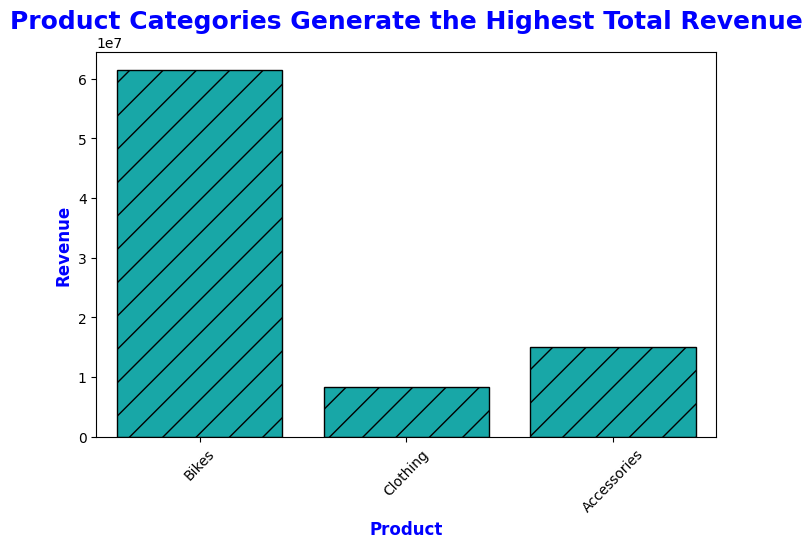

In [47]:
plt.figure(figsize=(8,5))
sns.barplot(data = pdf1, x = "Product_Category", y = "Total_Sell", color = 'c',hatch = "/", edgecolor = 'k')

plt.title("Product Categories Generate the Highest Total Revenue",
          fontdict={'color':'b','fontsize':18,'fontweight':'bold'})
plt.xlabel("Product",
           fontdict={'color':'blue', 'fontsize':12,'fontweight':'demibold'})
plt.ylabel("Revenue",
           fontdict={'color':'blue', 'fontsize':12,'fontweight':'heavy'})
plt.xticks(rotation=46)
plt.show()


# State by total revenue

In [48]:
State = pro_max.groupBy("State").agg(sum("Total_Sell").alias("Total_Sell")).orderBy("Total_Sell",ascending=False).limit(10)

In [51]:
pdf2 = State.toPandas()

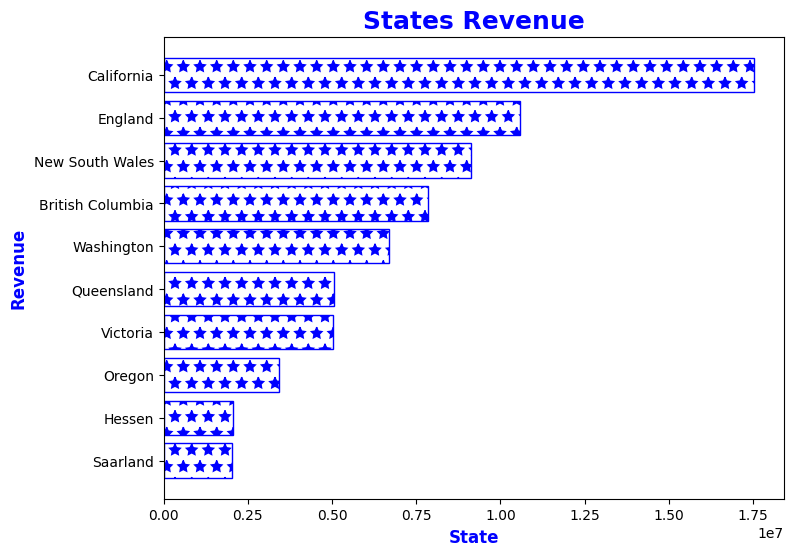

In [52]:
plt.figure(figsize=(8,6))

plt.barh(pdf2["State"],pdf2["Total_Sell"], edgecolor = "b", color = "w", hatch = "*")

plt.title("States Revenue",
         fontdict={'color':'b','fontsize':18,'fontweight':'bold'})
plt.xlabel("State",
           fontdict={'color':'blue', 'fontsize':12,'fontweight':'demibold'})
plt.ylabel("Revenue",
           fontdict={'color':'blue', 'fontsize':12,'fontweight':'heavy'})
plt.gca().invert_yaxis()   # Highest value at top
plt.show()


#  Country wise Profit

In [53]:
country = pro_max.groupBy("Country").agg(sum("Profit").alias("Profit"))

In [54]:
pdf3 = country.toPandas()

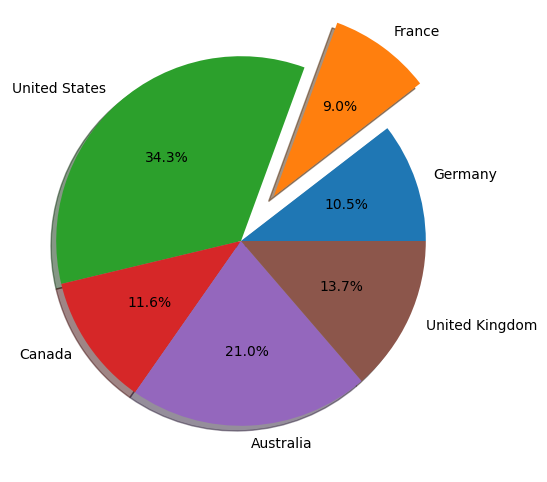

In [56]:
plt.figure(figsize=(8,6))
explode = (0,0.3,0,0,0,0)

plt.pie(pdf3["Profit"], labels=pdf3["Country"], shadow=True,explode=explode, autopct="%.1f%%")
plt.show()

# Every Countries revenue change over time (Yearly)

In [57]:
Revenue = pro_max.groupBy("Year","Country")  \
                 .agg(sum("Total_Sell").alias("monthly_revenue"))

In [58]:
pdf4 = Revenue.toPandas()

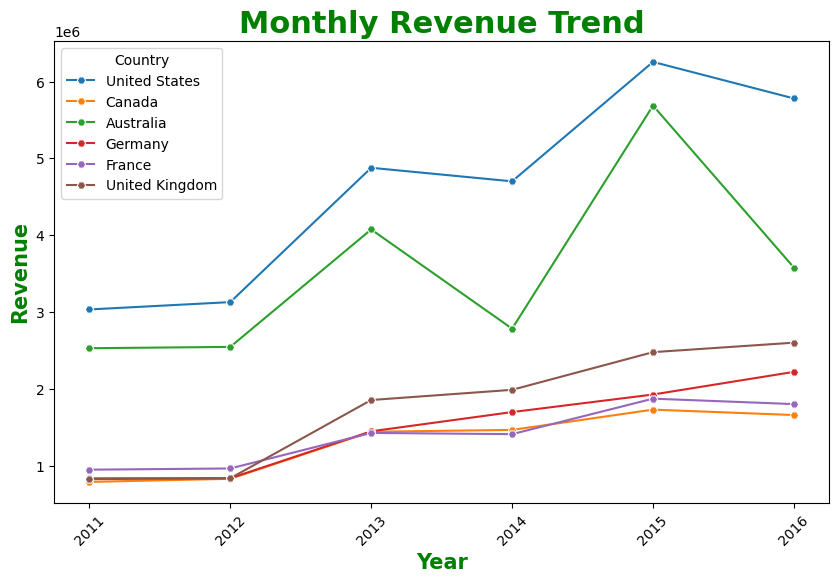

In [59]:
plt.figure(figsize=(10,6))
sns.lineplot(data = pdf4, x = "Year", y = "monthly_revenue",hue = "Country", marker = 'H')
plt.xlabel("Year",
          fontdict={'color':'g','fontsize':15,'fontweight':'bold'})
plt.ylabel("Revenue",
          fontdict={'color':'g','fontsize':15,'fontweight':'bold'})
plt.title("Monthly Revenue Trend",
         fontdict={'color':'g','fontsize':22,'fontweight':'bold'})
plt.xticks(rotation=45)
plt.show()

# How does revenue vary by year and month

In [60]:
from pyspark.sql.functions import when, col

pro_max_ultra = pro_max.withColumn(
    "Month_Num",
    when(col("Month") == "January", 1)
    .when(col("Month") == "February", 2)
    .when(col("Month") == "March", 3)
    .when(col("Month") == "April", 4)
    .when(col("Month") == "May", 5)
    .when(col("Month") == "June", 6)
    .when(col("Month") == "July", 7)
    .when(col("Month") == "August", 8)
    .when(col("Month") == "September", 9)
    .when(col("Month") == "October", 10)
    .when(col("Month") == "November", 11)
    .when(col("Month") == "December", 12)
)

In [61]:
heatmap = pro_max_ultra.groupBy("Year", "Month_Num")  \
      .agg(sum("Total_Sell").alias("total_revenue"))

In [62]:
pdf5 = heatmap.toPandas()


In [63]:
pivot_table = pdf5.pivot(index="Year", columns="Month_Num", values="total_revenue")



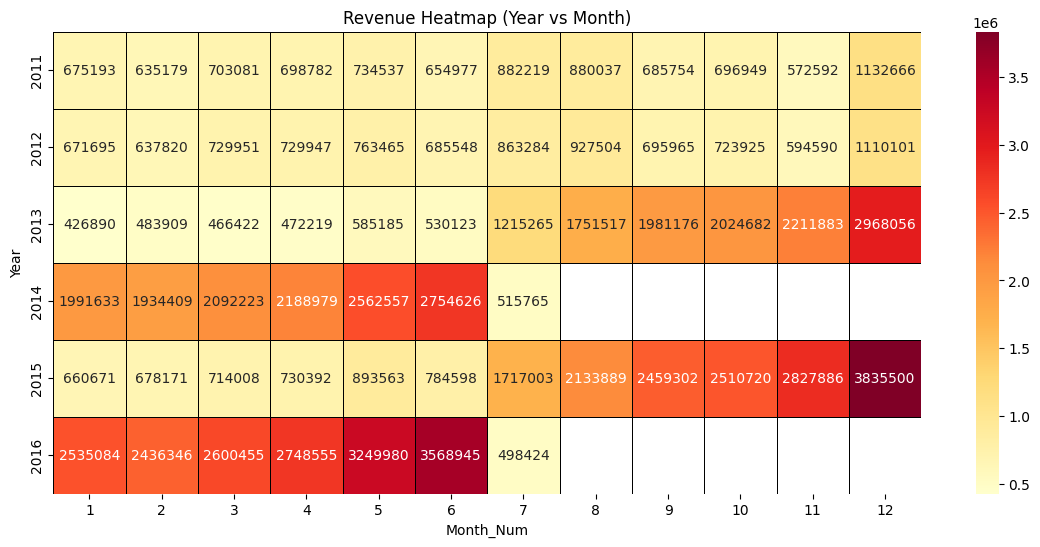

In [64]:
plt.figure(figsize=(14,6))
sns.heatmap(pivot_table, cmap="YlOrRd", annot=True, fmt=".0f",linewidths=0.5,linecolor="black")

plt.title("Revenue Heatmap (Year vs Month)")
plt.show()


In [65]:
print(pivot_table)


Month_Num         1          2          3          4          5          6   \
Year                                                                          
2011        675193.0   635179.0   703081.0   698782.0   734537.0   654977.0   
2012        671695.0   637820.0   729951.0   729947.0   763465.0   685548.0   
2013        426890.0   483909.0   466422.0   472219.0   585185.0   530123.0   
2014       1991633.0  1934409.0  2092223.0  2188979.0  2562557.0  2754626.0   
2015        660671.0   678171.0   714008.0   730392.0   893563.0   784598.0   
2016       2535084.0  2436346.0  2600455.0  2748555.0  3249980.0  3568945.0   

Month_Num         7          8          9          10         11         12  
Year                                                                         
2011        882219.0   880037.0   685754.0   696949.0   572592.0  1132666.0  
2012        863284.0   927504.0   695965.0   723925.0   594590.0  1110101.0  
2013       1215265.0  1751517.0  1981176.0  2024682.0  

In [66]:
pivot_table = pivot_table.fillna(0)


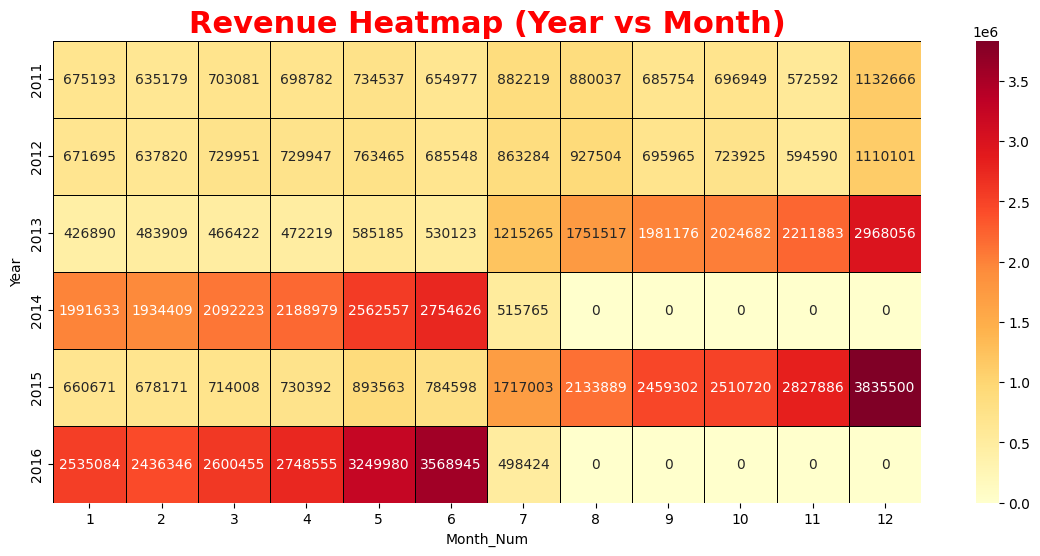

In [67]:
plt.figure(figsize=(14,6))
sns.heatmap(pivot_table, cmap="YlOrRd", annot=True, fmt=".0f",linewidths=0.5,linecolor="black")

plt.title("Revenue Heatmap (Year vs Month)",
         fontdict={'color':'r','fontsize':22,'fontweight':'bold'})
plt.show()

# Product_Category Cost Price and Selling Price

In [68]:
reg = pro_max_ultra.select("Product_Category","Total_Buying_Cost","Total_Sell")

pdf6 = reg.toPandas()

<Figure size 1000x1600 with 0 Axes>

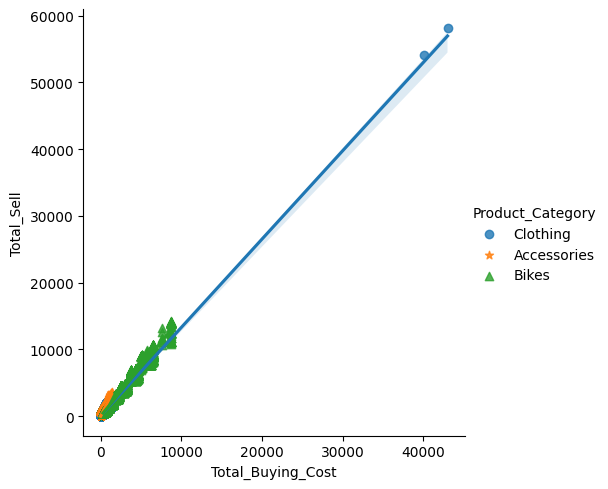

In [69]:
plt.figure(figsize=(10,16))
sns.lmplot(data = pdf6, x = "Total_Buying_Cost", y = "Total_Sell", hue = "Product_Category", markers = ["o","*","^"])

plt.show()

# How does order quantity impact profit

In [70]:
reg = pro_max_ultra.select("Order_Quantity","Profit")

pdf7 = reg.toPandas()

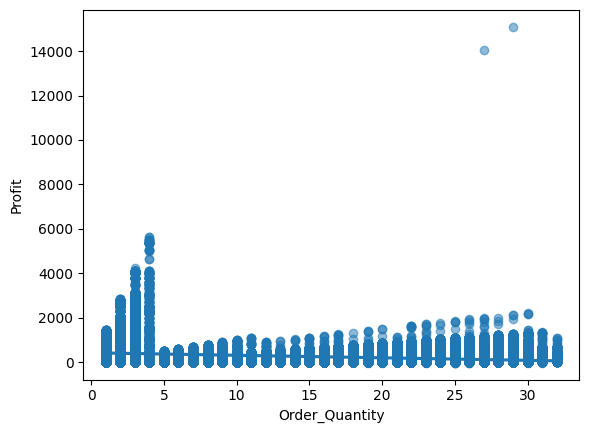

In [71]:
sns.regplot(data = pdf7, x = "Order_Quantity", y = "Profit", scatter_kws={"alpha": 0.5})
plt.show()

In [75]:
pro_max_ultra.coalesce(1).write.format("csv").option("header",True).option("inferSchema",True).save("/home/suhaib/csv_Folder/data_Folder/New_sales_file.csv")

In [76]:
pro_max_ultra.repartition(1).write.format("parquet").save("/home/suhaib//parquet_folder/New_sales_file.parquet")